# Library

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, precision_score, recall_score, f1_score)
import tensorflow as tf
from tensorflow.keras import layers
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.optimizers import Adam

# 한글 글꼴 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 전처리

In [2]:
# 파일 불러오기
file_path = r"C:\Users\james\J_Data_Lab\Project-DonationPrediction\data\koweps_1010is.csv"
df = pd.read_csv(file_path)
df.head()

,h_cobf,h_reg5,h_reg7,h_din,h_cin,h_flag,h_hc,h01_1,h01_110,h_hc_all,...,h08_106_was_missing,h08_107_was_missing,h08_108_was_missing,h08_109_was_missing,h08_110_was_missing,h08_111_was_missing,h08_aq9_was_missing,h10_aq7_was_missing,h10_aq18_was_missing,h10_aq26_was_missing
0,0.0,1,1,858.8,896.0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
1,0.0,1,1,1260.8,1310.0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
2,0.0,1,1,2172.0,2208.0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0.0,1,1,864.0,864.0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1
4,0.0,1,1,1159.0,1171.0,1,0,1,1,0,...,1,1,1,1,1,1,1,1,1,1


In [3]:
df = df.drop(columns=['p_cp', 'h_g1'])

In [4]:
# 분석대상(Y) 
y = df['donation'].astype(int)

# 독립 변수(X) 설정 (p04_4와 p04_5를 제외한 나머지)
x = df.drop(columns=['p04_4', 'p04_5', 'donation'])

# 샘플링 및 모델링

In [5]:
# 분할 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤 언더샘플링
ros = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

# 스케일링
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)

# 모델 정의 
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'MLP': MLPClassifier(max_iter=1000)
}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    print(f'------{name}------')
    
    model.fit(x_train_scaled, y_train_resampled)
    y_pred = model.predict(x_test_scaled)
    
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(x_test_scaled)

    # 평가 지표
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 결과 저장
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1,
        'Accuracy': accuracy,
        'AUC': roc_auc
    })

results_df = pd.DataFrame(results)
#results_df


------Logistic Regression------
------Random Forest------
------XGBoost------


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\xgboost\core.py:158: UserWarning: [02:03:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


------LightGBM------
[LightGBM] [Info] Number of positive: 11867, number of negative: 11867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18844
[LightGBM] [Info] Number of data points in the train set: 23734, number of used features: 310
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
------CatBoost------
------MLP------


In [6]:
# CNN
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# CNN 모델 학습 및 평가 추가
input_shape = (x_train_scaled.shape[1], 1) 
cnn_model = create_cnn_model(input_shape)

# reshape 
x_train_cnn = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_cnn = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

cnn_model.fit(x_train_cnn, y_train_resampled, epochs=10, batch_size=32, verbose=1)

# CNN 테스트 데이터로 예측
y_pred_cnn = cnn_model.predict(x_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int) 

# CNN 평가 지표 계산
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
tn, fp, fn, tp = cm_cnn.ravel()
specificity_cnn = tn / (tn + fp)

y_pred_proba_cnn = cnn_model.predict(x_test_cnn)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# 저장
results.append({
    'Algorithm': 'CNN',
    'Precision': precision_cnn,
    'Recall': recall_cnn,
    'Specificity': specificity_cnn,
    'F1-score': f1_cnn,
    'Accuracy': accuracy_cnn,
    'AUC': roc_auc_cnn
})

results_df = pd.DataFrame(results)
results_df

Epoch 1/10


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


742/742 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7287 - loss: 0.5377
Epoch 2/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7750 - loss: 0.4688
Epoch 3/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7875 - loss: 0.4532
Epoch 4/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7873 - loss: 0.4514
Epoch 5/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7863 - loss: 0.4479
Epoch 6/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7820 - loss: 0.4494
Epoch 7/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7874 - loss: 0.4426
Epoch 8/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7906 - loss: 0.4443
Epoch 9/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7960 - loss: 0.4366
Epoch 10/10
742/742 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7933 - loss: 0.4415
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,Logistic Regression,0.986115,0.754251,0.816650,0.854738,0.757667,0.869292
1,Random Forest,0.988644,0.739355,0.853387,0.846018,0.745599,0.874483
2,XGBoost,0.987221,0.764637,0.829120,0.861789,0.768168,0.878112
3,LightGBM,0.987929,0.762158,0.839232,0.860480,0.766378,0.883002
4,CatBoost,0.988614,0.764481,0.847995,0.862220,0.769053,0.885996
5,MLP,0.982080,0.744665,0.765420,0.847052,0.745802,0.833815
6,CNN,0.987248,0.746637,0.833502,0.850248,0.751393,0.873293


# 전체 기부특성 분석

In [7]:
xgb_model = models['XGBoost']

# 예측 수행
y_test_pred = xgb_model.predict(x_test_scaled)
y_test_proba = xgb_model.predict_proba(x_test_scaled)

# DataFrame
test_results = pd.DataFrame(x_test_scaled, columns=x_test.columns)
test_results['Actual'] = y_test.reset_index(drop=True)
test_results['Predicted'] = y_test_pred
test_results['Donation_Probability'] = y_test_proba[:, 1]

# 기부 확률이 높은 상위 10명
top_donors = test_results.sort_values(by='Donation_Probability', ascending=False).head(10)
top_donors

,h_cobf,h_reg5,h_reg7,h_din,h_cin,h_flag,h_hc,h01_1,h01_110,h_hc_all,...,h08_109_was_missing,h08_110_was_missing,h08_111_was_missing,h08_aq9_was_missing,h10_aq7_was_missing,h10_aq18_was_missing,h10_aq26_was_missing,Actual,Predicted,Donation_Probability
5860,0.0,0.50,0.500000,0.146740,0.140571,1.0,0.0,0.250,0.25,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999981
10323,0.0,0.50,0.833333,0.153534,0.147365,1.0,0.0,0.500,1.00,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999970
17836,0.0,0.50,0.500000,0.147562,0.142320,0.0,0.0,0.500,1.00,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999960
42131,0.0,0.50,0.833333,0.160981,0.155361,1.0,1.0,0.500,1.00,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999956
49700,0.0,0.75,0.500000,0.155972,0.150183,1.0,1.0,0.500,1.00,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999951
37956,0.0,0.00,0.000000,0.165260,0.161580,1.0,1.0,0.375,1.00,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999945
3098,0.0,0.25,0.666667,0.186667,0.187205,1.0,0.0,0.500,1.00,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999942
23110,0.0,0.75,0.833333,0.155586,0.150049,1.0,1.0,0.500,1.00,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999940
10626,0.0,0.75,0.333333,0.147937,0.141944,1.0,0.0,0.375,0.50,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999940
43386,0.0,0.50,0.166667,0.164982,0.165434,1.0,1.0,0.375,1.00,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,1,0.999938


# SHAP 분석

In [14]:
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

# 변수 매핑 
variable_mapping = {
    'h_eco1': '가구원번호',
    'h_soc_13': '건강보험 가입여부',
    'h_g6': '교육수준',
    'h_eco4': '주된 경제활동 참여상태',
    'h_med8': '건강검진 횟수',
    'h_g4': '태어난 연도',
    'h_med2': '건강상태',
    'h_g2': '가구주와의 관계',
    'h01_1': '가구원수',
    'h_g11': '종교',
    'p03_1': '인터넷 사용 여부',
    'p03_11': '여가생활만족도',
    'h_cin': '경상소득',
    'p05_26' : '나에 대해 대체로 만족',
    'h_inc2_1' : '상용근로자 해당여부',
    'p05_20' : '나는 가치 있는 사람',
    'p05_25' : '긍정적인 태도',
    'h07_3aq13' : '기타소비지출',
    'h07_9' :  '총생활비',
    'h07_4' : '세금',
    'h07_3aq11' : '교양오락비' ,
    'h07_6aq6' : '종교관련비(십일조)',
    'h07_5' : '사회보장부담금',
    'h05_3aq2' : '민간의료보험의 12월 기준 보험료',
    'h07_5aq1' : '식료품비 - 주류 및 담배',
    'h08_6aq3' : '세금환급금',
    'h10_aq7' : '금융자산-적금',
    'p03_9' : '직업 만족도',
    'h08_aq9' : '이자, 배당금, 연간소득',
    'h10_27' : '소유한 자동차 가격',
    'h08_aq34' : '민간 개인 또는 단체로 부터 받은 보조금',
    'h17_1' : '1년간 근심이나 갈등을 초래한 문제',
    'h07_3aq9' : '교육비-공교육비',
    'h07_6aq7' : '세금-소득세',
    'h07_6aq14' : '사회보장부담-고용보험료',
    'h07_6aq13' : '사회보장부담-건강보험료',
    'h06_4' : '(주택)방수',
    'h07_3aq15' : '부모에게 보낸 월평금 송금보조비',
    'h07_6aq8' : '재산세',
    'h07_6aq1' : '광열수도비- 난방비',
    'p_cp' : '최종조사결과 확인',
    'h_g1' : '가구원 번호',
    'h_g7': ' 교육수준2',
    'h07_3aq7' : '피복신발비',
    'h_g3' : '성별',
    'p02_1' : '근로유형',
    'h_med10' : '민간의료보험 가입건수',
    'h_soc_2' : '공적연금가입형태',
    'p03_6' : '가족의 수입 만족도',
    'h_g10' : '혼인상태',
    'h_reg5': '5개 권역별 지역구분'
}

# 매핑된 변수로 변경 
x_test_scaled_df.rename(columns=variable_mapping, inplace=True)

# 피처 리스트
feature_names = x_test_scaled_df.columns.tolist()

In [9]:
# SHAP Explainer 생성
explainer = shap.TreeExplainer(xgb_model)

# SHAP 값 계산
shap_values = explainer.shap_values(x_test_scaled_df)

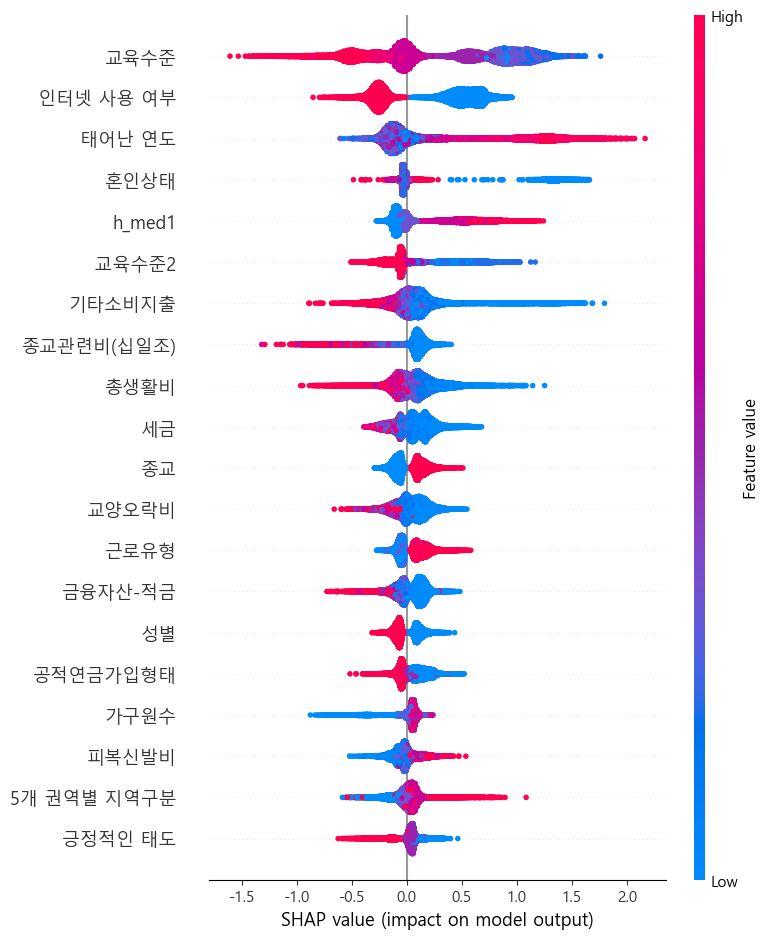

In [15]:
# SHAP Summary Plot
shap.summary_plot(shap_values, x_test_scaled_df, feature_names=feature_names)

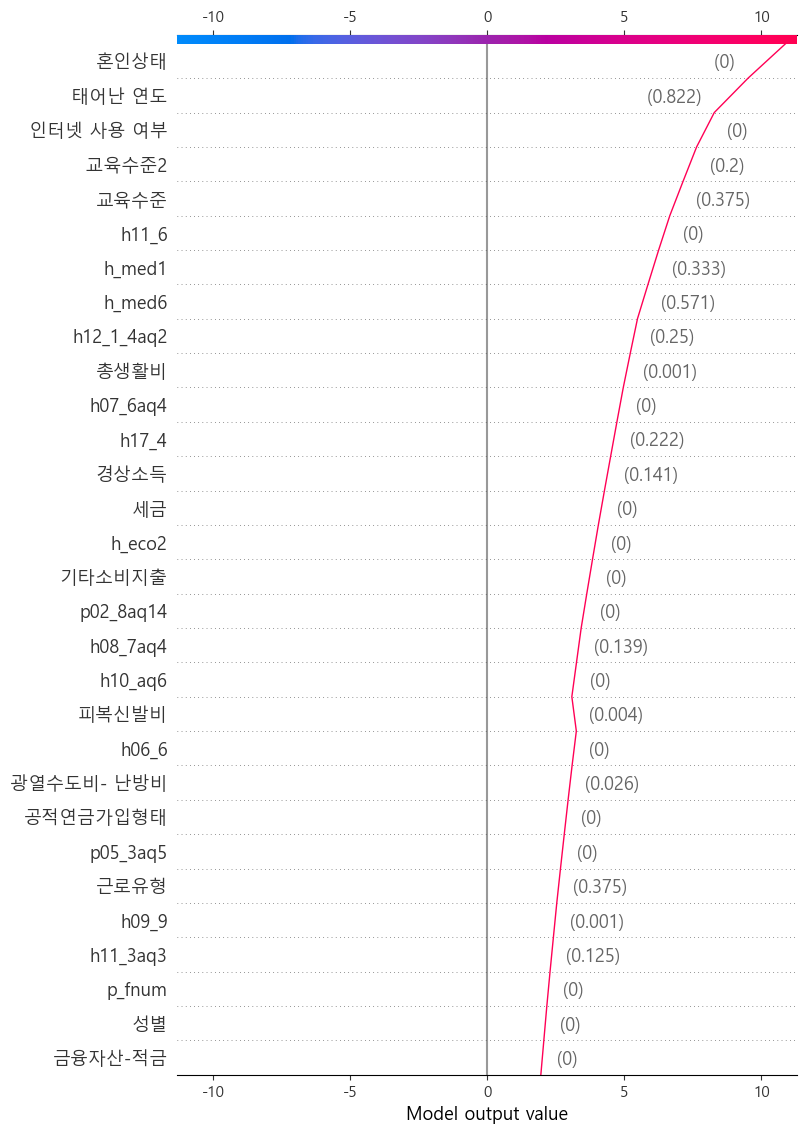

In [16]:
# Decision Plot 
instance_index = 5860  # 인덱스

shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[instance_index],
    features=x_test_scaled_df.iloc[instance_index],
    feature_names=feature_names,
    feature_display_range=slice(None, -31, -1)  
)


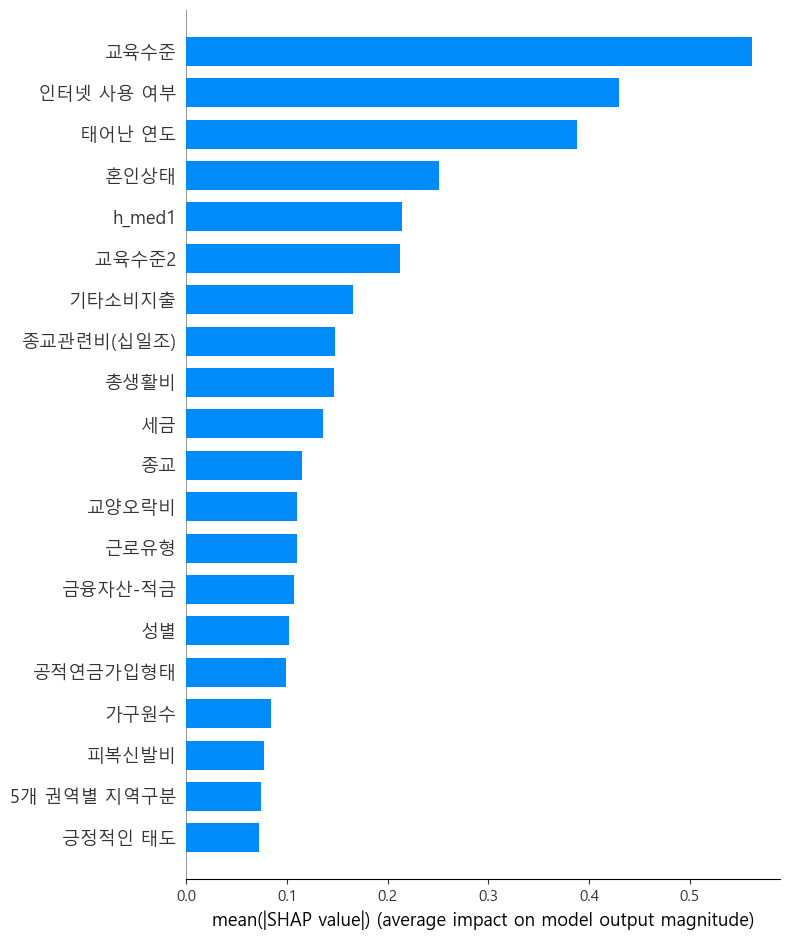

In [17]:
# 중요도 막대 그래프 
shap.summary_plot(shap_values, x_test_scaled_df, feature_names=feature_names, plot_type="bar")